In [1]:
from food.tools import *
from food.paths import *
from food.psql import *
import requests
from food.qdrant import *
import torch
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=1, eps=1e-08)
import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

import shapely
import shapely.geometry
from PIL import ImageFont, ImageDraw, Image

dev


In [2]:
def read_image_from_url(url=None,path=None):
    if url: response = requests.get(url, stream=True)
    if path: pass
    return Image.open(response.raw)

In [3]:
def crop_image_to_square(img):
    height = img.size[1]//2*2
    left  = int((img.size[0]-height)/2)
    right =      img.size[0]-left
    return img.crop((left,0,right,height))

In [4]:
def box_area(box):
    return (box[2]-box[0])*(box[3]-box[1])

In [5]:
series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])

In [6]:
def norm(v): 
    return v/torch.linalg.norm(v, dim=-1, keepdim=True)

In [7]:
foods = read_sql('foods')

# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')
foods = foods.dropna()

In [8]:
food_clips = series2tensor(foods['clip'])

/tmp/ipykernel_2126329/2423156918.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])


In [9]:
food_clips.shape

torch.Size([7083, 768])

In [10]:
def search_clip(url,head = 1):
    image_clip = requests.post(f'http://127.0.0.1:8182/image2vector/?url={url}').json()
    image_clip = torch.tensor(image_clip)
    df = foods.copy()
    df['score'] = cos(food_clips,image_clip)
    df = df.sort_values('score',ascending=False)[:head]

    return image_clip,df.reset_index()

In [11]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [15.00, 15.0]
plt.rcParams["figure.autolayout"] = True

In [12]:
url = 'https://image.shutterstock.com/z/stock-photo-healthy-salad-bowl-with-quinoa-tomatoes-chicken-avocado-lime-and-mixed-greens-lettuce-parsley-521741356.jpg'
image = get_image_from_url(url)
image = crop_image_to_square(image)
total_size = image.size[0]*image.size[1]

In [13]:
image.size

(1102, 1102)

In [14]:
thershold = 0.15
params = {'url':url,'thershold':thershold}
boxes,mask = requests.post('http://127.0.0.1:8185/get_boxes/?',params = params).json()
mask = np.array(mask)

In [15]:
len(boxes)

10

In [16]:
df = pd.DataFrame()
df['area'] = [box_area(box) for box in boxes]
df['boxes'] = boxes
df = df.reset_index()

In [17]:
photo_id = url.split('/')[-1]
urls = []
for d in df[['index','boxes']].to_dict('records'):
    id,box = d.values()
    urls.append(f'https://dima.grankin.eu/fragment_reference_images/{photo_id}_{id}.jpg')
clip_df = pd.DataFrame()
for u in urls:
    clip_df = clip_df.append(search_clip(u,head = 1)[1])
clip_df = clip_df.reset_index(drop = True)[['description','score','category','energy','protein','carb','fat']]#,

/tmp/ipykernel_2126329/2750536250.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_2126329/2750536250.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_2126329/2750536250.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_2126329/2750536250.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_2126329/2750536250.py:8: FutureWarning: The frame.append method is deprec

In [18]:
df = clip_df.join(df)
df = df[df['score']>0.24]
df = df.sort_values('area',ascending = False)
df = df.reset_index(drop=True).reset_index()
df = df.rename(columns = {'level_0':'box_area_rank'})
# df = df.sort_values('box_area_rank',ascending = False)
df['boxes'] = df['boxes'].apply(lambda b:[int(bb) for bb in b])

In [19]:
# df = df[df['area']<total_size*0.5]

In [20]:
arrays= []
for row in df[['box_area_rank','energy','boxes']].iterrows():
    
    row = row[1]
    b = row['boxes']
    rank   = np.zeros(image.size)
    rank  [b[1]:b[3],b[0]:b[2]] = row['box_area_rank']
    
    energy = np.zeros(image.size)
    energy  [b[1]:b[3],b[0]:b[2]]= row['energy']
    
    row_array = np.stack([rank,energy])
    arrays.append(row_array)
arrays = np.stack(arrays)
arrays = arrays*mask.T

In [22]:
classes =  arrays[:,0,:,:].max(0)
df_count_classes = df[['box_area_rank','description']].set_index('box_area_rank').reindex(classes.reshape(classes.shape[0]*classes.shape[0]))
df_count_classes = df_count_classes.dropna().reset_index().groupby('description').count().sort_values('box_area_rank',ascending = False).head(20)
df_count_classes['%'] = (df_count_classes['box_area_rank']/df_count_classes['box_area_rank'].sum()).round(2)
r = df_count_classes[['%']].join(df.drop_duplicates('description').set_index('description')[['category','energy','protein','carb','fat']])
r = r[r['%']>0.005]
r

,%,category,energy,protein,carb,fat
description,,,,,,
"Quinoa, no added fat",0.73,"Pasta, noodles, cooked grains",120.0,4.38,21.21,1.91
"Bread, wheat or cracked wheat, reduced calorie and/or high fiber",0.09,Yeast breads,207.0,8.91,44.91,2.55
"Chicken breast, baked, broiled, or roasted, skin not eaten, from raw",0.08,"Chicken, whole pieces",161.0,30.22,0.00,3.52
"Avocado, raw",0.05,Other vegetables and combinations,160.0,2.00,8.53,14.66
"Lime, raw",0.03,Citrus fruits,30.0,0.70,10.54,0.20
"Chicken breast, baked, broiled, or roasted with marinade, skin not eaten, from raw",0.01,"Chicken, whole pieces",174.0,29.13,0.31,5.38


In [23]:
get_image_from_url(urls[17])

IndexError: list index out of range

In [24]:
colories_tensor = np.where((arrays[:,0,:,:] == arrays[:,0,:,:].max(0)),arrays[:,1,:,:],0).max(0)
colories_tensor[colories_tensor!=0].mean()

146.17218714882884

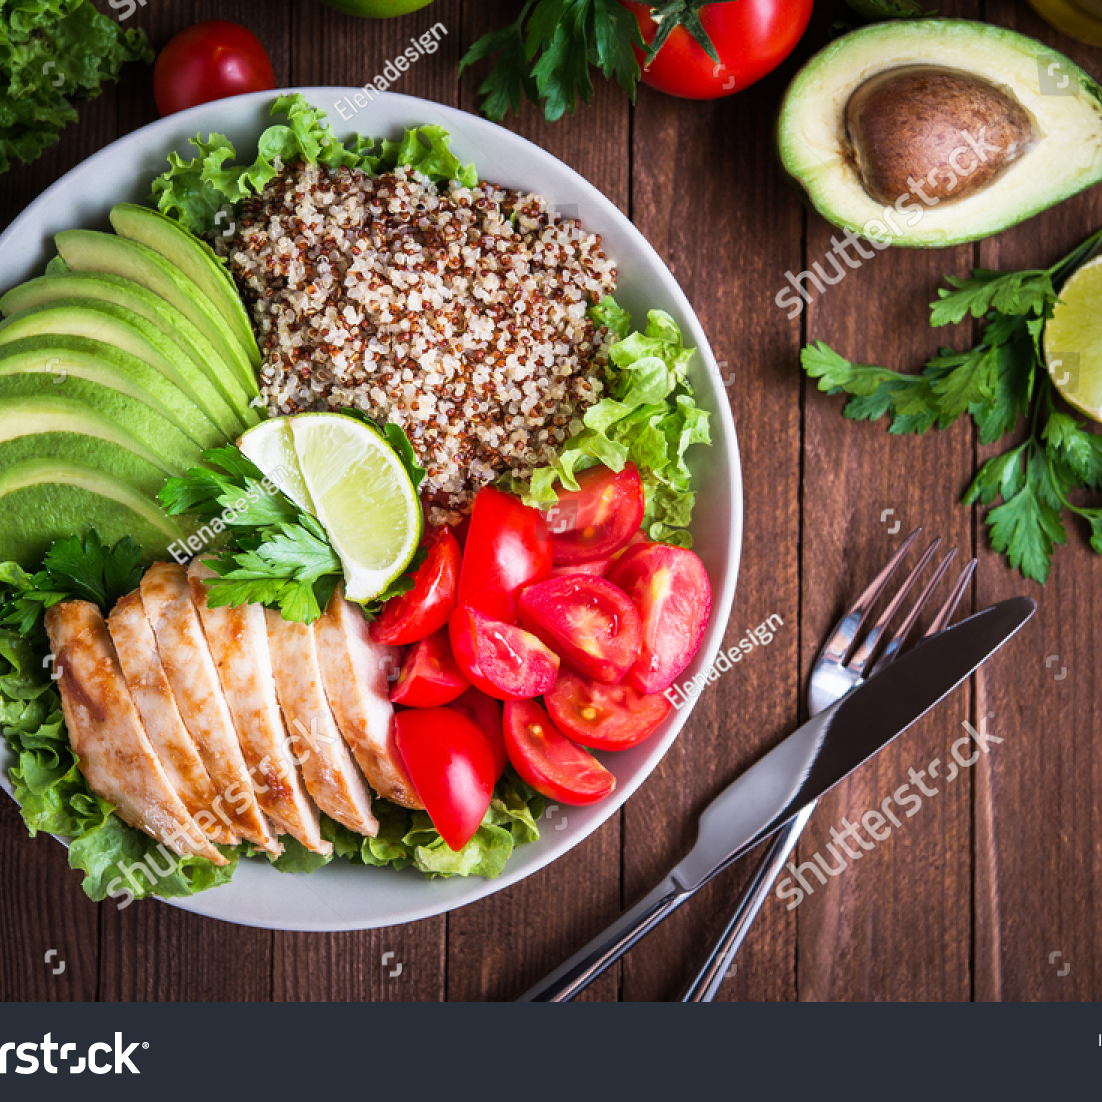

In [25]:
image

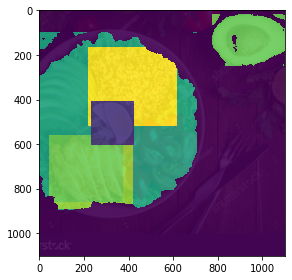

In [26]:
fig, ax = plt.subplots()
ax.imshow(image)
ax.imshow(colories_tensor, interpolation='none', alpha=0.9)